# Deep learning framework example: Named Entity Recognition

This notebook demonstrates how to use the deeplearning API to train and test the model on the [CoNNL 2003 dataset](https://www.clips.uantwerpen.be/conll2003/ner/).  The task is to identify named entities (i.e. people, organizations etc).

**Important**: Please see the Movie Review notebook example in the `zensols.movie` API first, as it contains more explaination of how the framework is used.  The purpose of this notebook is to run the MNIST dataset and visualize the results.

In [1]:
from harness import NotebookHarness
harness = NotebookHarness()
mng = harness()
#mng = harness(1, 'target2')

## Print information about 

Use the factory to create the model executor.  The `write` method gives statistics on the data set that is configured on the executor.

In [2]:
from zensols.config import Writable
# set indention level for human readable (pretty print) output
Writable.WRITABLE_INDENT_SPACE = 2
facade = mng.create_facade('glove50')
facade.write()

2021-08-06 09:18:18,703 [zensols.deeplearn.model.facade] creating new executor
2021-08-06 09:18:19,592 [zensols.deepnlp.embed.wordtext] reading binary vector file: ../corpus/glove/bin/6B.50/vec.dat
2021-08-06 09:18:19,895 [zensols.deepnlp.embed.wordtext] loaded 400000 vectors in 0s
2021-08-06 09:18:20,249 [zensols.deepnlp.embed.wordtext] prepared vectors in 0s
2021-08-06 09:18:20,250 [zensols.deepnlp.embed.domain] created tensor vectory matrix on use cuda: True, device: cuda:0


executor:
  model: NER: glove_50 
  feature splits:
    split stash splits:
      test: 3453 (16.6%)
      train: 14041 (67.7%)
      dev: 3250 (15.7%)
      total: 20744


2021-08-06 09:18:23,942 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, device: cuda:0


    total this instance: 20744
    keys consistent: True
    delegate:
      key splits:
        test: 3453 (16.6%)
        train: 14041 (67.7%)
        dev: 3250 (15.7%)
      total: 20744
  batch splits:
    split stash splits:
      test: 108 (16.6%)
      train: 439 (67.6%)
      dev: 102 (15.7%)
      total: 649
    total this instance: 649
    keys consistent: True
    delegate:
      name: sent_batch_stash
      chunk_size: 0
      workers: 2
      batch_size: 32
      data_point_id_sets_path: ../data/batch/b32/keys.dat
      batch_limit: 9223372036854775807
      delegate_attr: True
      _has_data: True
      is_child: False
      _decoded_attributes: {'tags', 'glove_50_embedding', 'ents', 'syns', 'mask'}
      priming: False
  network settings:
    name: net_settings
    recurrent_crf_settings:
      name: recurrent_crf_settings
      dropout: 0.1
      network_type: lstm
      bidirectional: True
      hidden_size: 24
      num_layers: 1
      num_labels: 9
      decoder_set

## Train and test the model

Train and test the model with the default (low) number of epochs to make sure everything is working.

2021-08-06 09:18:23,955 [zensols.deeplearn.model.executor.status] resetting executor
2021-08-06 09:18:23,956 [zensols.deeplearn.model.facade] training...
2021-08-06 09:18:23,964 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-08-06 09:18:23,965 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: gpu
2021-08-06 09:18:23,965 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for train
2021-08-06 09:18:28,045 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for dev
2021-08-06 09:18:28,947 [zensols.deeplearn.model.executor.status] loaded 541 batches in 4s
2021-08-06 09:18:28,948 [zensols.deeplearn.model.executor.status] train/test sets: 439 102
2021-08-06 09:18:28,953 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, device: cuda:0
2021-08-06 09:18:28,995 [zensols.deeplearn.model.executor.status] 

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.001
  train:
    started: 08/06/2021 09:18:29:050184
    ended: 08/06/2021 09:19:06:989918
    batches: 439
    ave data points per batch/total: 32.0/14041
    min/ave/max loss: 1539.73608/3707.11770/7965.04328
  validation:
    started: 08/06/2021 09:18:46:773547
    ended: 08/06/2021 09:19:09:741244
    batches: 102
    ave data points per batch/total: 503.5/51362
    converged/epochs: 2/2
    min/ave/max loss: 1345.47699/3050.42521/9157.01098
    accuracy: 0.944 (48497/51362)
    micro: F1: 0.944, precision: 0.944, recall: 0.944
    macro: F1: 0.607, precision: 0.785, recall: 0.590
    weighted: F1: 0.936, precision: 0.940, recall: 0.944
  test:
    started: 08/06/2021 09:19:11:403262
    ended: 08/06/2021 09:19:12:819761
    batches: 108
    ave data points per batch/total: 430.0/46435
    min/ave/max loss: 0.00000/0.00000/0.00000
    accuracy: 0.940 (43654/46435)
    micro: F1: 0.940, precision: 0.940, recall: 0.940
    macro: 

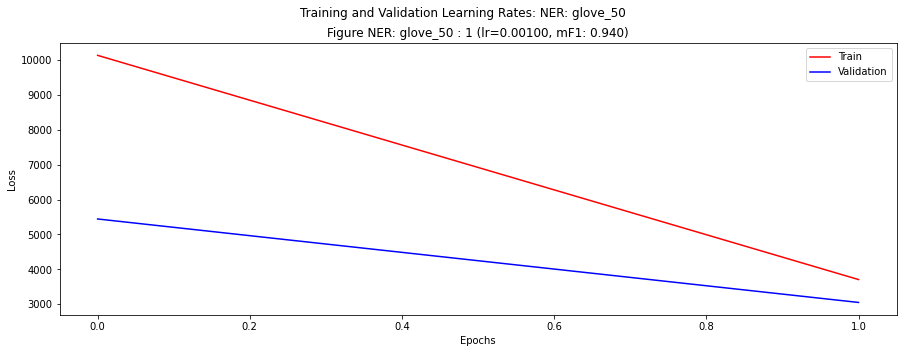

In [3]:
facade.epochs = 2
mng.run()

## Tune hyperparameters

Set model parameters to get a feel for where they need to be before changing features.  Start with Glove 50 dimensional word embeddings with a learning rate of 0.01 and 20 epochs.

2021-08-06 09:19:13,321 [zensols.deeplearn.model.executor.status] resetting executor
2021-08-06 09:19:13,322 [zensols.deeplearn.model.facade] training...
2021-08-06 09:19:13,324 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 2
2021-08-06 09:19:13,324 [zensols.deeplearn.model.executor.status] train/test sets: 439 102
2021-08-06 09:19:13,404 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, device: cuda:0
2021-08-06 09:19:13,446 [zensols.deeplearn.model.executor.status] training model <class 'zensols.deepnlp.layer.embrecurcrf.EmbeddedRecurrentCRF'> on cuda:0 for 10 epochs using learning rate 0.01
tr:474.571|va min:1055.598|va:1169.002|lr:0.01 /\: 100%|████████████████████████████████| 10/10 [03:23<00:00, 20.16s/it]2021-08-06 09:22:36,718 [zensols.deeplearn.model.executor.status] epoch threshold reached at 10
2021-08-06 09:22:36,718 [zensols.deeplearn.model.executor.status] final minimum 

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.01
  train:
    started: 08/06/2021 09:19:13:449223
    ended: 08/06/2021 09:22:33:992921
    batches: 439
    ave data points per batch/total: 32.0/14041
    min/ave/max loss: 59.54613/474.57114/1699.38886
  validation:
    started: 08/06/2021 09:19:30:729633
    ended: 08/06/2021 09:22:36:716020
    batches: 102
    ave data points per batch/total: 503.5/51362
    converged/epochs: 5/10
    min/ave/max loss: 300.67016/1055.59843/3338.76575
    accuracy: 0.976 (50105/51362)
    micro: F1: 0.976, precision: 0.976, recall: 0.976
    macro: F1: 0.866, precision: 0.890, recall: 0.847
    weighted: F1: 0.975, precision: 0.975, recall: 0.976
  test:
    started: 08/06/2021 09:22:37:057516
    ended: 08/06/2021 09:22:38:384376
    batches: 108
    ave data points per batch/total: 430.0/46435
    min/ave/max loss: 0.00000/0.00000/0.00000
    accuracy: 0.967 (44883/46435)
    micro: F1: 0.967, precision: 0.967, recall: 0.967
    macro: F1: 

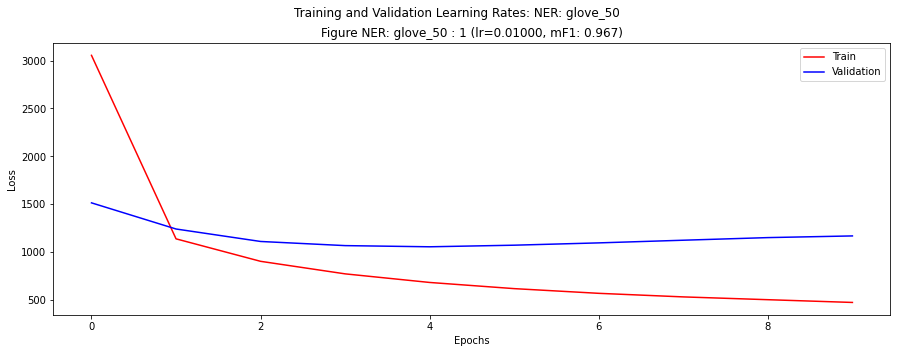

In [4]:
facade.learning_rate = 0.01
facade.epochs = 10
mng.run()

# Glove 300 embeddings

Next we use the same learning rate, but switch to the 300 dimension version of the embeddings.  The number of epochs is reduced because I have run the test before I know at what epoch the validation loss converges.  Since the model is saved only when the validation loss decreases, we early stop at 8 epochs.

2021-08-06 09:22:38,747 [zensols.deepnlp.embed.wordtext] reading binary vector file: ../corpus/glove/bin/6B.300/vec.dat
2021-08-06 09:22:39,346 [zensols.deepnlp.embed.wordtext] loaded 400000 vectors in 0s
2021-08-06 09:22:40,099 [zensols.deepnlp.embed.wordtext] prepared vectors in 0s
2021-08-06 09:22:40,100 [zensols.deepnlp.embed.domain] created tensor vectory matrix on use cuda: True, device: cuda:0
2021-08-06 09:22:40,259 [zensols.deeplearn.model.facade] clearing
2021-08-06 09:22:40,535 [zensols.deeplearn.model.facade] creating new executor
2021-08-06 09:22:40,547 [zensols.deepnlp.embed.wordtext] reading binary vector file: ../corpus/glove/bin/6B.300/vec.dat
2021-08-06 09:22:41,134 [zensols.deepnlp.embed.wordtext] loaded 400000 vectors in 0s
2021-08-06 09:22:41,915 [zensols.deepnlp.embed.wordtext] prepared vectors in 0s
2021-08-06 09:22:41,917 [zensols.deepnlp.embed.domain] created tensor vectory matrix on use cuda: True, device: cuda:0
2021-08-06 09:22:42,096 [zensols.deeplearn.mode

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.01
  train:
    started: 08/06/2021 09:22:47:783623
    ended: 08/06/2021 09:25:38:610761
    batches: 439
    ave data points per batch/total: 32.0/14041
    min/ave/max loss: 32.46873/278.06192/1428.36177
  validation:
    started: 08/06/2021 09:23:06:163939
    ended: 08/06/2021 09:25:41:789139
    batches: 102
    ave data points per batch/total: 503.5/51362
    converged/epochs: 3/8
    min/ave/max loss: 187.00793/1071.06605/3612.62720
    accuracy: 0.978 (50225/51362)
    micro: F1: 0.978, precision: 0.978, recall: 0.978
    macro: F1: 0.884, precision: 0.897, recall: 0.872
    weighted: F1: 0.978, precision: 0.978, recall: 0.978
  test:
    started: 08/06/2021 09:25:43:775567
    ended: 08/06/2021 09:25:45:372179
    batches: 108
    ave data points per batch/total: 430.0/46435
    min/ave/max loss: 0.00000/0.00000/0.00000
    accuracy: 0.964 (44785/46435)
    micro: F1: 0.964, precision: 0.964, recall: 0.964
    macro: F1: 0

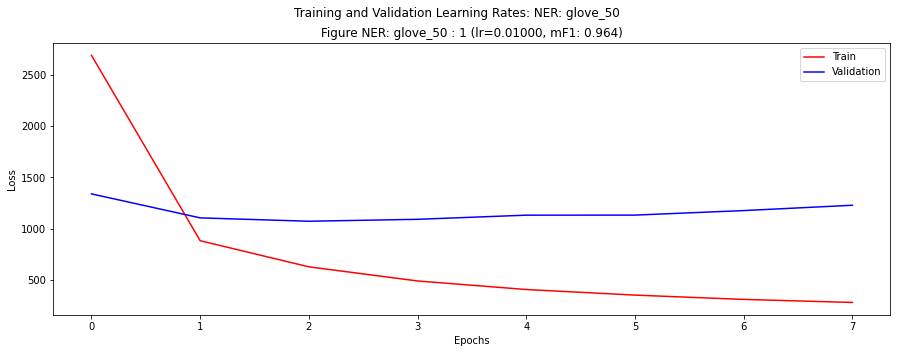

In [5]:
facade.epochs = 8
facade.embedding = 'glove_300_embedding'
mng.run()

# Word2vec Embeddings

Now we switch to the Google 300D word2vec pretrained vectors using 12 epochs, even though it has converged at 9 epochs previously.

2021-08-06 09:25:45,755 [zensols.deepnlp.embed.word2vec] reading binary vector file
2021-08-06 09:25:45,756 [zensols.deepnlp.embed.word2vec] loading keyed file: ../corpus/word2vec/GoogleNews-vectors-negative300.bin
2021-08-06 09:26:40,726 [zensols.deepnlp.embed.word2vec] loaded key model from /home/landes/view/nlp/deepnlp/example/ner/notebook/../corpus/word2vec/GoogleNews-vectors-negative300.bin in 54s
2021-08-06 09:26:40,727 [zensols.deepnlp.embed.word2vec] loaded word2vec model in 54s
2021-08-06 09:26:53,539 [zensols.deepnlp.embed.word2vec] created data structures in 12s
2021-08-06 09:26:55,940 [zensols.deepnlp.embed.domain] created tensor vectory matrix on use cuda: True, device: cuda:0
2021-08-06 09:26:57,138 [zensols.deeplearn.model.facade] clearing
2021-08-06 09:26:57,340 [zensols.deeplearn.model.facade] creating new executor
2021-08-06 09:26:57,352 [zensols.deepnlp.embed.word2vec] reading binary vector file
2021-08-06 09:26:57,353 [zensols.deepnlp.embed.word2vec] loading keyed f

Name: NER: glove_50 : 1
Run index: 2
Learning rate: 0.01
  train:
    started: 08/06/2021 09:28:19:830970
    ended: 08/06/2021 09:32:40:295137
    batches: 439
    ave data points per batch/total: 32.0/14041
    min/ave/max loss: 13.17482/129.39439/615.11305
  validation:
    started: 08/06/2021 09:28:38:400794
    ended: 08/06/2021 09:32:43:496131
    batches: 102
    ave data points per batch/total: 503.5/51362
    converged/epochs: 4/12
    min/ave/max loss: 192.49699/916.00018/3143.01009
    accuracy: 0.980 (50337/51362)
    micro: F1: 0.980, precision: 0.980, recall: 0.980
    macro: F1: 0.889, precision: 0.902, recall: 0.879
    weighted: F1: 0.980, precision: 0.980, recall: 0.980
  test:
    started: 08/06/2021 09:32:50:683711
    ended: 08/06/2021 09:32:52:273697
    batches: 108
    ave data points per batch/total: 430.0/46435
    min/ave/max loss: 0.00000/0.00000/0.00000
    accuracy: 0.968 (44932/46435)
    micro: F1: 0.968, precision: 0.968, recall: 0.968
    macro: F1: 0.

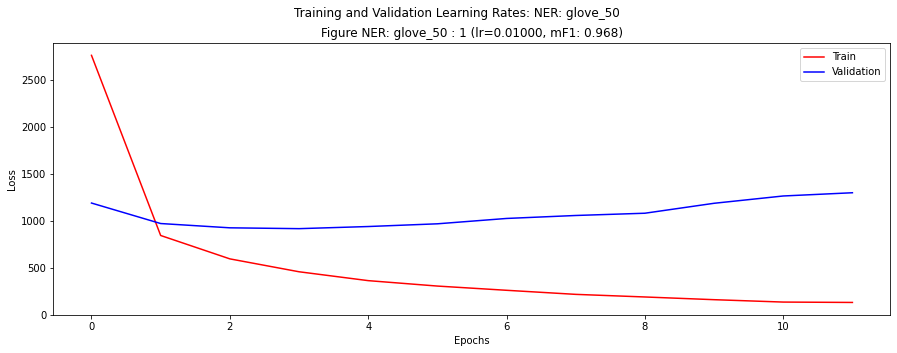

In [6]:
facade.epochs = 12
facade.embedding = 'word2vec_300_embedding'
mng.run()

# BERT Embeddings

Now we test with Bert context aware frozen (not trainable) embeddings using 10 epochs.  We must empty the `net_settings` attributes, which are the lingustic features, since Bert tokenizes using the word piece algorithm and the tensor shapes will not align.  We'll address this later.

2021-08-06 09:32:54,305 [zensols.deeplearn.model.facade] creating new executor
2021-08-06 09:32:58,079 [zensols.deeplearn.model.executor.status] resetting executor
2021-08-06 09:32:58,080 [zensols.deeplearn.model.facade] training...
2021-08-06 09:32:58,151 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-08-06 09:32:58,152 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: gpu
2021-08-06 09:32:58,152 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for train
2021-08-06 09:32:59,331 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for dev
2021-08-06 09:32:59,607 [zensols.deeplearn.model.executor.status] loaded 541 batches in 1s
2021-08-06 09:32:59,609 [zensols.deeplearn.model.executor.status] train/test sets: 439 102
2021-08-06 09:32:59,987 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, de

Name: NER: transformer_trainable : 1
Run index: 2
Learning rate: 5e-05
  train:
    started: 08/06/2021 09:33:00:167230
    ended: 08/06/2021 10:32:13:743531
    batches: 439
    ave data points per batch/total: 463.8/203621
    min/ave/max loss: 1.13798/2.41786/7.25515
  validation:
    started: 08/06/2021 09:46:46:860898
    ended: 08/06/2021 10:33:30:454966
    batches: 102
    ave data points per batch/total: 503.5/51362
    converged/epochs: 1/4
    min/ave/max loss: 0.32051/2.26096/7.00217
    accuracy: 0.988 (50757/51362)
    micro: F1: 0.988, precision: 0.988, recall: 0.988
    macro: F1: 0.934, precision: 0.940, recall: 0.928
    weighted: F1: 0.988, precision: 0.988, recall: 0.988
  test:
    started: 08/06/2021 10:33:40:761790
    ended: 08/06/2021 10:34:56:453044
    batches: 108
    ave data points per batch/total: 430.0/46435
    min/ave/max loss: 0.39617/4.20035/9.72218
    accuracy: 0.980 (45513/46435)
    micro: F1: 0.980, precision: 0.980, recall: 0.980
    macro: F1:

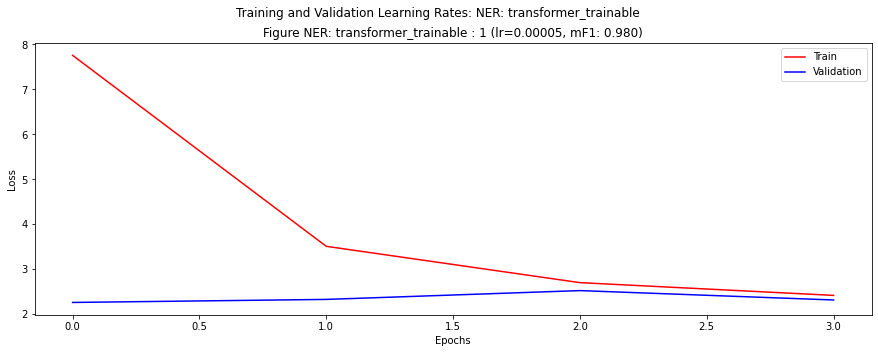

In [7]:
facade = mng.create_facade('transformer-trainable')
mng.run()
facade.persist_result()

2021-08-06 10:35:03,329 [zensols.deeplearn.model.facade] creating new executor
2021-08-06 10:35:06,605 [zensols.deeplearn.model.executor.status] resetting executor
2021-08-06 10:35:06,606 [zensols.deeplearn.model.facade] training...
2021-08-06 10:35:06,673 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-08-06 10:35:06,674 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: gpu
2021-08-06 10:35:06,675 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for train
2021-08-06 10:35:07,686 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for dev
2021-08-06 10:35:07,926 [zensols.deeplearn.model.executor.status] loaded 541 batches in 1s
2021-08-06 10:35:07,927 [zensols.deeplearn.model.executor.status] train/test sets: 439 102
2021-08-06 10:35:08,080 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, de

Name: NER: transformer_trainable : 1
Run index: 2
Learning rate: 5e-05
  train:
    started: 08/06/2021 10:35:08:248103
    ended: 08/06/2021 11:49:38:231918
    batches: 439
    ave data points per batch/total: 463.8/203621
    min/ave/max loss: 1.09504/2.24048/5.38957
  validation:
    started: 08/06/2021 10:48:58:243017
    ended: 08/06/2021 11:50:54:938647
    batches: 102
    ave data points per batch/total: 503.5/51362
    converged/epochs: 2/5
    min/ave/max loss: 0.18607/2.17608/9.05081
    accuracy: 0.989 (50817/51362)
    micro: F1: 0.989, precision: 0.989, recall: 0.989
    macro: F1: 0.943, precision: 0.945, recall: 0.942
    weighted: F1: 0.989, precision: 0.989, recall: 0.989
  test:
    started: 08/06/2021 11:51:07:072183
    ended: 08/06/2021 11:52:22:727090
    batches: 108
    ave data points per batch/total: 430.0/46435
    min/ave/max loss: 0.38573/5.13140/15.77601
    accuracy: 0.979 (45466/46435)
    micro: F1: 0.979, precision: 0.979, recall: 0.979
    macro: F1

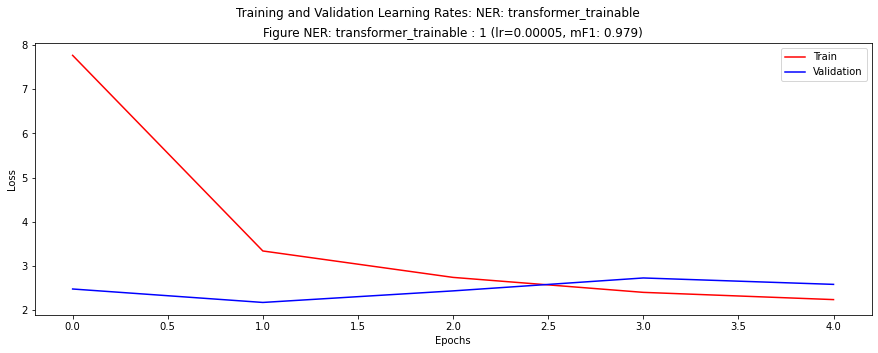

In [8]:
mng.clear()
facade = mng.create_facade('transformer-trainable')
facade.net_settings.add_attributes = ('syns_expander', 'tags_expander')
facade.epochs = 5
mng.run()

2021-08-06 11:52:23,747 [zensols.deeplearn.model.facade] creating new executor
2021-08-06 11:52:27,195 [zensols.deeplearn.model.executor.status] resetting executor
2021-08-06 11:52:27,195 [zensols.deeplearn.model.facade] training...
2021-08-06 11:52:27,265 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-08-06 11:52:27,265 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: gpu
2021-08-06 11:52:27,266 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for train
2021-08-06 11:52:28,314 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for dev
2021-08-06 11:52:28,576 [zensols.deeplearn.model.executor.status] loaded 541 batches in 1s
2021-08-06 11:52:28,577 [zensols.deeplearn.model.executor.status] train/test sets: 439 102
2021-08-06 11:52:28,751 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, de

Name: NER: transformer_trainable : 1
Run index: 2
Learning rate: 5e-05
  train:
    started: 08/06/2021 11:52:28:937737
    ended: 08/06/2021 13:53:10:091780
    batches: 439
    ave data points per batch/total: 463.8/203621
    min/ave/max loss: 1.60305/3.46813/7.64789
  validation:
    started: 08/06/2021 12:06:21:535044
    ended: 08/06/2021 13:54:26:850790
    batches: 102
    ave data points per batch/total: 503.5/51362
    converged/epochs: 5/8
    min/ave/max loss: 3.13739/8.02066/16.90124
    accuracy: 0.955 (49038/51362)
    micro: F1: 0.955, precision: 0.955, recall: 0.955
    macro: F1: 0.806, precision: 0.833, recall: 0.784
    weighted: F1: 0.954, precision: 0.954, recall: 0.955
  test:
    started: 08/06/2021 13:54:46:191792
    ended: 08/06/2021 13:56:01:828451
    batches: 108
    ave data points per batch/total: 430.0/46435
    min/ave/max loss: 4.85991/11.41611/23.49188
    accuracy: 0.940 (43639/46435)
    micro: F1: 0.940, precision: 0.940, recall: 0.940
    macro: 

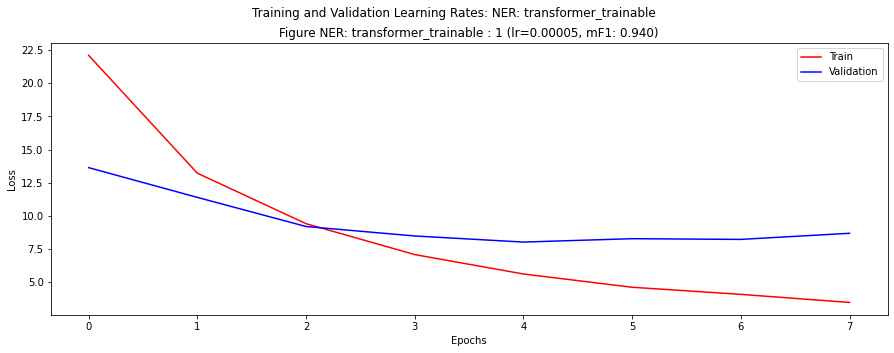

In [9]:
mng.clear()
mng.config('transformer_trainable_resource', model_id='roberta-base')
facade = mng.create_facade('transformer-trainable')
facade.epochs = 8
mng.run()

2021-08-06 13:56:02,867 [zensols.deeplearn.model.facade] creating new executor
2021-08-06 13:56:05,877 [zensols.deeplearn.model.executor.status] resetting executor
2021-08-06 13:56:05,878 [zensols.deeplearn.model.facade] training...
2021-08-06 13:56:05,947 [zensols.deeplearn.model.executor.status] batch iteration: gpu, limit: 9223372036854775807, caching: True, cached: 0
2021-08-06 13:56:05,948 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: gpu
2021-08-06 13:56:05,948 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for train
2021-08-06 13:56:06,991 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for dev
2021-08-06 13:56:07,236 [zensols.deeplearn.model.executor.status] loaded 541 batches in 1s
2021-08-06 13:56:07,237 [zensols.deeplearn.model.executor.status] train/test sets: 439 102
2021-08-06 13:56:07,390 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, de

Name: NER: transformer_trainable : 1
Run index: 2
Learning rate: 5e-05
  train:
    started: 08/06/2021 13:56:07:555918
    ended: 08/06/2021 15:10:46:627331
    batches: 439
    ave data points per batch/total: 463.8/203621
    min/ave/max loss: 1.07732/2.67066/8.51573
  validation:
    started: 08/06/2021 14:09:57:813657
    ended: 08/06/2021 15:12:03:322105
    batches: 102
    ave data points per batch/total: 503.5/51362
    converged/epochs: 3/5
    min/ave/max loss: 0.22760/2.03229/8.48899
    accuracy: 0.990 (50845/51362)
    micro: F1: 0.990, precision: 0.990, recall: 0.990
    macro: F1: 0.944, precision: 0.946, recall: 0.943
    weighted: F1: 0.990, precision: 0.990, recall: 0.990
  test:
    started: 08/06/2021 15:12:15:261701
    ended: 08/06/2021 15:13:30:873936
    batches: 108
    ave data points per batch/total: 430.0/46435
    min/ave/max loss: 0.31513/4.34103/12.21207
    accuracy: 0.982 (45578/46435)
    micro: F1: 0.982, precision: 0.982, recall: 0.982
    macro: F1

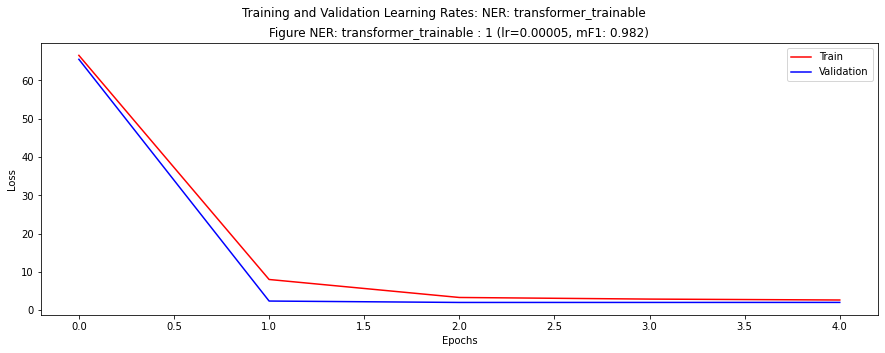

In [10]:
import logging
logging.getLogger('zensols.deepnlp.transformer.optimizer').setLevel(logging.INFO)
mng.clear()
mng.config('model_settings',
           scheduler_class_name='zensols.deepnlp.transformer.TransformerSchedulerFactory',
           scheduler_params="dict: {'name': 'linear', 'num_warmup_steps': 0.01}")
facade = mng.create_facade('transformer-trainable')
facade.epochs = 5
mng.run()

2021-08-06 15:13:31,804 [zensols.deeplearn.model.facade] creating new executor
2021-08-06 15:13:38,519 [zensols.deeplearn.model.executor.status] resetting executor
2021-08-06 15:13:38,520 [zensols.deeplearn.model.facade] training...
2021-08-06 15:13:38,706 [zensols.deeplearn.model.executor.status] batch iteration: cpu, limit: 9223372036854775807, caching: True, cached: 0
2021-08-06 15:13:38,707 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: cpu
2021-08-06 15:13:38,708 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for train
2021-08-06 15:13:40,785 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for dev
2021-08-06 15:13:41,271 [zensols.deeplearn.model.executor.status] loaded 2163 batches in 2s
2021-08-06 15:13:41,272 [zensols.deeplearn.model.executor.status] train/test sets: 1756 407
2021-08-06 15:13:42,020 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, 

Name: transformer_trainable_large: 1
Run index: 2
Learning rate: 5e-05
  train:
    started: 08/06/2021 15:13:42:554689
    ended: 08/06/2021 19:14:51:924341
    batches: 1756
    ave data points per batch/total: 116.0/203621
    min/ave/max loss: 0.16887/6.01280/19.58584
  validation:
    started: 08/06/2021 15:58:48:693870
    ended: 08/06/2021 19:18:31:348293
    batches: 407
    ave data points per batch/total: 126.2/51362
    converged/epochs: 4/5
    min/ave/max loss: 3.54585/8.06422/13.56347
    accuracy: 0.833 (42759/51362)
    micro: F1: 0.833, precision: 0.833, recall: 0.833
    macro: F1: 0.101, precision: 0.093, recall: 0.111
    weighted: F1: 0.756, precision: 0.693, recall: 0.833
  test:
    started: 08/06/2021 19:18:50:643421
    ended: 08/06/2021 19:22:25:646746
    batches: 432
    ave data points per batch/total: 107.5/46435
    min/ave/max loss: 3.20257/8.14883/16.46267
    accuracy: 0.825 (38323/46435)
    micro: F1: 0.825, precision: 0.825, recall: 0.825
    macro:

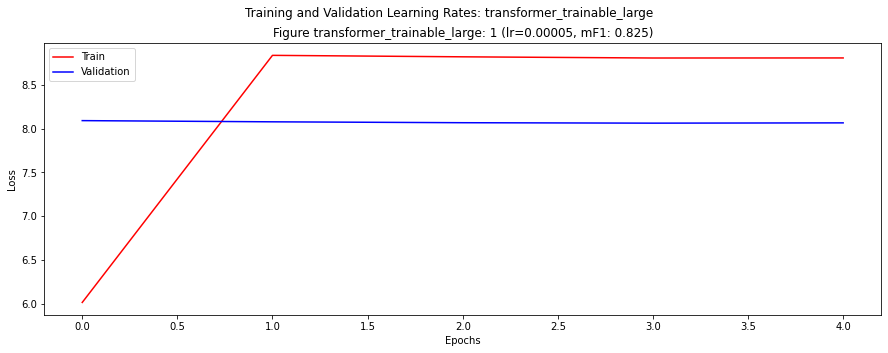

In [11]:
mng.clear()
facade = mng.create_facade('transformer-trainable-large')
mng.run()

total allocations: 22494
<class 'ner.domain.NERBatch'>: 11247
<class 'zensols.persist.annotation.PersistedWork'>: 11247


2021-08-06 19:22:27,829 [zensols.deeplearn.model.facade] creating new executor
2021-08-06 19:22:34,094 [zensols.deeplearn.model.executor.status] resetting executor
2021-08-06 19:22:34,095 [zensols.deeplearn.model.facade] training...
2021-08-06 19:22:34,269 [zensols.deeplearn.model.executor.status] batch iteration: cpu, limit: 9223372036854775807, caching: True, cached: 0
2021-08-06 19:22:34,269 [zensols.deeplearn.model.executor.status] preparing datasets using iteration: cpu
2021-08-06 19:22:34,270 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for train
2021-08-06 19:22:35,989 [zensols.deeplearn.model.executor.status] using batch limit: 9223372036854775807 for dev
2021-08-06 19:22:36,404 [zensols.deeplearn.model.executor.status] loaded 2163 batches in 2s
2021-08-06 19:22:36,404 [zensols.deeplearn.model.executor.status] train/test sets: 1756 407
2021-08-06 19:22:36,849 [zensols.deeplearn.model.executor.status] created model on cpu with use cuda: True, 

Name: transformer_trainable_large: 1
Run index: 2
Learning rate: 5e-05
  train:
    started: 08/06/2021 19:22:37:330120
    ended: 08/07/2021 03:29:23:680323
    batches: 1756
    ave data points per batch/total: 116.0/203621
    min/ave/max loss: 0.14257/0.97061/5.37606
  validation:
    started: 08/06/2021 20:07:43:524436
    ended: 08/07/2021 03:33:03:159768
    batches: 407
    ave data points per batch/total: 126.2/51362
    converged/epochs: 10/10
    min/ave/max loss: 0.00524/0.59564/6.20543
    accuracy: 0.987 (50713/51362)
    micro: F1: 0.987, precision: 0.987, recall: 0.987
    macro: F1: 0.920, precision: 0.927, recall: 0.915
    weighted: F1: 0.987, precision: 0.987, recall: 0.987
  test:
    started: 08/07/2021 03:33:55:039492
    ended: 08/07/2021 03:37:28:852448
    batches: 432
    ave data points per batch/total: 107.5/46435
    min/ave/max loss: 0.00447/1.12750/7.43141
    accuracy: 0.980 (45521/46435)
    micro: F1: 0.980, precision: 0.980, recall: 0.980
    macro: 

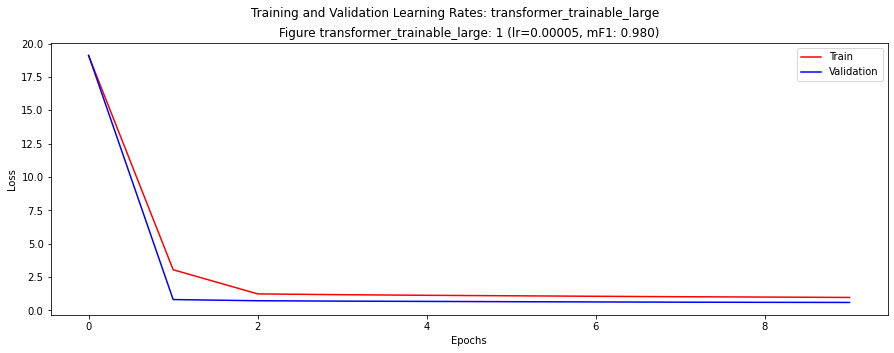

In [12]:
import logging
logging.getLogger('zensols.deepnlp.transformer.optimizer').setLevel(logging.INFO)
mng.clear()
mng.config('model_settings',
           scheduler_class_name='zensols.deepnlp.transformer.TransformerSchedulerFactory',
           scheduler_params="dict: {'name': 'linear', 'num_warmup_steps': 0.01}")
facade = mng.create_facade('transformer-trainable-large')
facade.epochs = 10
mng.run()